In [14]:
import pandas as pd
from IPython.display import Image
import shutil
import os

import seaborn as sns
import matplotlib.pyplot as plt

from fastai.vision.all import *

import warnings
warnings.filterwarnings('ignore')

In [15]:
PATH_IMG_TRAIN = 'data/input/train_folder/'
DEFAULT_FIGSIZE = (7,6)

labels = {
    0: 'plantation',
    1: 'grassland',
    2: 'smallholder_agriculture',
}

In [16]:
df_test = pd.read_csv('data/input/raw/test.csv')
df_train = pd.read_csv('data/input/raw/train.csv')

df_test.example_path = df_test.example_path.str.replace('train_test_data','data/input/raw')
df_train.example_path = df_train.example_path.str.replace('train_test_data','data/input/raw')

df_train.head()

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,data/input/raw/train/1297.png
1,2,-1.989349,105.309496,2013,data/input/raw/train/1199.png
2,0,1.223256,100.702217,2014,data/input/raw/train/1348.png
3,0,-2.342948,103.890226,2008,data/input/raw/train/2214.png
4,0,-0.126555,101.758175,2011,data/input/raw/train/2220.png


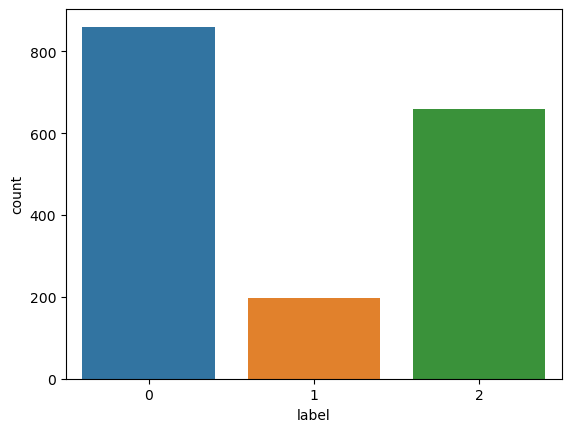

In [17]:
sns.countplot(x ='label', data = df_train)
plt.show()


<AxesSubplot:xlabel='year'>

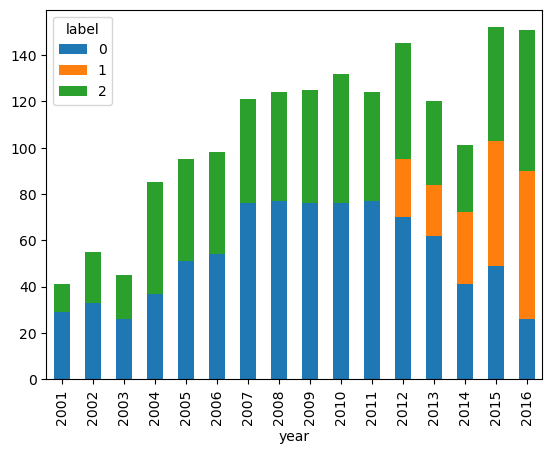

In [18]:
# sns.countplot(x ='year', data = df_train)
# plt.show()

df_plot = df_train.groupby(['year', 'label']).size().reset_index().pivot(columns='label', index='year', values=0)
df_plot.plot(kind='bar', stacked=True)

In [19]:
import plotly.express as px
fig = px.scatter_geo(df_train,lat='latitude',lon='longitude', hover_name="label",color="year")
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

In [20]:
fig = px.scatter_geo(df_train,lat='latitude',lon='longitude', hover_name="year",color="label")
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

# Prepare data

In [21]:

for label in labels:
    os.makedirs(os.path.dirname(f'data/input/train_folder/{labels[label]}/'), exist_ok=True)

for example_path, label in zip(df_train.example_path, df_train.label):
    source_file = example_path
    filename = source_file.split('/')[-1]
    destination_file = f'data/input/train_folder/{labels[label]}/{labels[label]}-{filename}'
    shutil.copyfile(source_file, destination_file)

In [22]:
image_categories = os.listdir(PATH_IMG_TRAIN)
print(f"Categories: {image_categories}")

Categories: ['grassland', 'plantation', 'smallholder_agriculture']


# Entrenamiento modelo

In [23]:
def GetLabel(fileName):
    return fileName.split('-')[0]

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


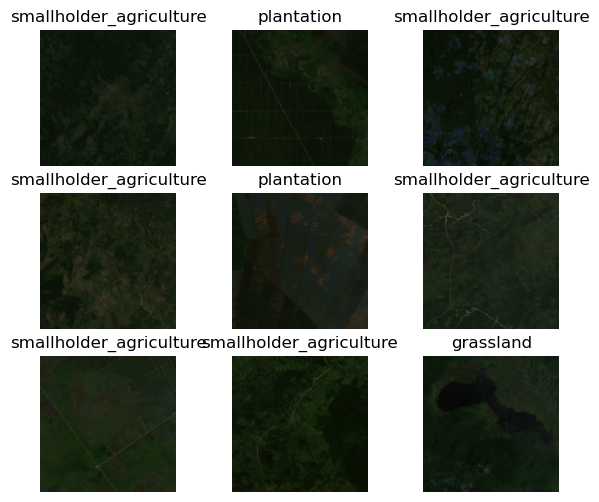

In [24]:
# Defining data loader
dls = ImageDataLoaders.from_name_func(
    PATH_IMG_TRAIN,
    get_image_files(PATH_IMG_TRAIN),
    valid_pct=0.2,
    seed=42,
    label_func=GetLabel,
    item_tfms=Resize(224),
    device=torch.device('cpu'),
    shuffle_train=True
    )

dls.train.show_batch(figsize=DEFAULT_FIGSIZE)

In [25]:
# Train model for 10 epochs
learn = vision_learner(
    dls,
    resnet34,
    metrics=accuracy,
    pretrained=True
    )
learn.dls.cpu()
learn.fine_tune(epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.527492,0.980694,0.678363,05:13


epoch,train_loss,valid_loss,accuracy,time
0,1.010326,0.838554,0.728070,06:14
1,0.683676,0.950988,0.722222,06:11
2,0.427976,0.941844,0.739766,07:20
3,0.282671,0.934705,0.739766,07:16


# Resultados Modelo

In [26]:
# Plot training metrics function
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

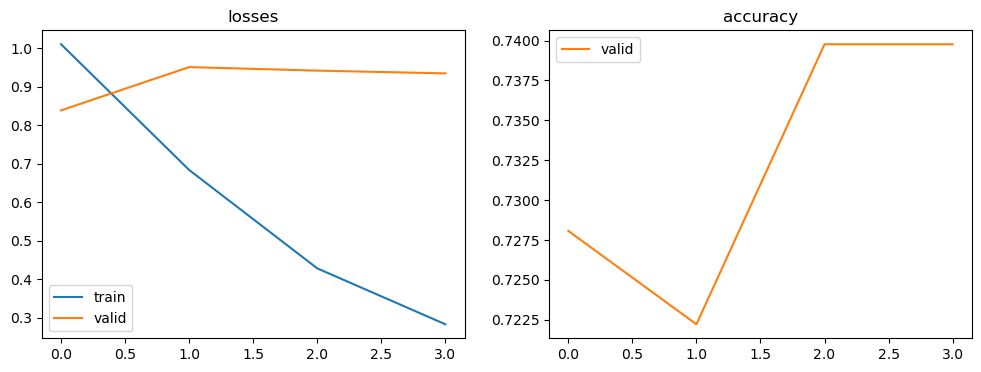

In [27]:
learn.recorder.plot_metrics()

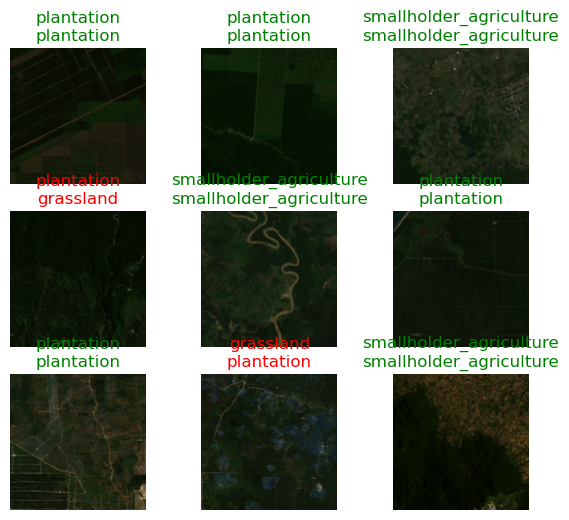

In [28]:
learn.show_results(figsize=DEFAULT_FIGSIZE)

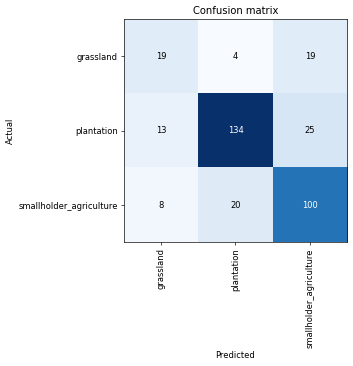

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=DEFAULT_FIGSIZE, dpi=60)

In [30]:
interp.print_classification_report()

                         precision    recall  f1-score   support

              grassland       0.47      0.45      0.46        42
             plantation       0.85      0.78      0.81       172
smallholder_agriculture       0.69      0.78      0.74       128

               accuracy                           0.74       342
              macro avg       0.67      0.67      0.67       342
           weighted avg       0.74      0.74      0.74       342



# Predictions

In [31]:
df_test.head()

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,data/input/raw/test/69.png
1,-8.059785,113.053791,2007,data/input/raw/test/469.png
2,-2.006610,111.746316,2002,data/input/raw/test/6.png
3,0.901765,114.042495,2016,data/input/raw/test/351.png
4,1.911210,100.829633,2008,data/input/raw/test/1001.png


In [32]:
predictions = dict()
df_test['target'] = df_test.example_path.apply(lambda x: int(learn.predict(x)[1]))

In [33]:
df_test.head()

,latitude,longitude,year,example_path,target
0,0.761681,122.755954,2006,data/input/raw/test/69.png,2
1,-8.059785,113.053791,2007,data/input/raw/test/469.png,2
2,-2.006610,111.746316,2002,data/input/raw/test/6.png,1
3,0.901765,114.042495,2016,data/input/raw/test/351.png,0
4,1.911210,100.829633,2008,data/input/raw/test/1001.png,2


In [34]:
df_test.target.to_json('predictions.json')